In [7]:
import pandas
import nltk
import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation
from numpy import array as np_array


TENSED_POS_TAGS = ['VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
STANCE_INDICES = {'FAVOR': 0, 'NONE': 1, 'AGAINST': 2}
TAG_SET = {}


def pos_tag(s):
    return nltk.pos_tag(nltk.word_tokenize(s))


def add_to_tag_set(s):
    tags = nltk.pos_tag(nltk.word_tokenize(s['Tweet']))
    for tag in tags:
        if tag[1] in TAG_SET:
            TAG_SET[tag[1]] = TAG_SET[tag[1]] + 1
        else:
            TAG_SET[tag[1]] = 1


def get_tag_set(rows):
    list(map(add_to_tag_set, rows))


def tag_is_tensed(tag):
    return tag[1] in TAG_SET


def get_target_rows(d_frame, target):
    if target == 'ALL':
        return list(
            map((lambda x: x[1]), d_frame.iterrows()))
    return list(
        filter((lambda row: row['Target'] == target),
            map((lambda x: x[1]), d_frame.iterrows())))


def get_tensed_tagged_words(rows):
    return list(
        map(
            (lambda row:
                list(filter(tag_is_tensed, pos_tag(row['Tweet'])))),
            rows))


def tensed_tag_counts(tags):
    just_tags = list(map((lambda x: x[1]), tags))
    return list(map((lambda tag: just_tags.count(tag)), TENSED_POS_TAGS))


def get_x_train(tags_for_tweets):
    return list(map(tensed_tag_counts, tags_for_tweets))


def onehot_for_stance(stance):
    one_hot = [0,0,0]
    one_hot[STANCE_INDICES[stance]] = 1
    return one_hot


def get_y_train(rows):
    return list(
        map(onehot_for_stance,
            map((lambda row: row['Stance']), rows)))


def get_xy_data(filename, target):
    training_df = pandas.read_csv(filename, sep='\t', encoding='latin1')
    target_rows = get_target_rows(training_df, target)
    # Get tags
    get_tag_set(target_rows)
    tensed_tagged_tweets = get_tensed_tagged_words(target_rows)
    x_train = get_x_train(tensed_tagged_tweets)
    y_train = get_y_train(target_rows)
    return (x_train, y_train)

# Training the model

In [10]:
labels = {
    'ALL': 'ALL',
    'HILLARY': 'Hillary Clinton',
    'ABORTION': 'Legalization of Abortion'
}

(x_train, y_train) = get_xy_data('trainingdata.txt', labels['ALL'])
(x_test, y_test) = get_xy_data('trialdata.txt', labels['ALL'])

{'WRB': 388, 'DT': 3371, 'FW': 17, 'VBD': 681, ')': 97, 'RP': 175, 'RBS': 37, '#': 6540, 'NNS': 2445, 'IN': 4387, 'NNPS': 91, 'CC': 1184, 'LS': 2, 'UH': 36, 'MD': 790, 'VB': 2546, 'TO': 1229, '.': 3495, 'JJ': 4296, 'CD': 605, 'WDT': 115, '$': 36, ':': 664, '(': 75, '``': 237, 'WP$': 5, 'NN': 7469, 'PDT': 35, 'VBP': 2018, 'JJR': 136, 'VBN': 698, 'NNP': 10429, 'POS': 265, "''": 254, 'JJS': 118, 'RBR': 63, 'SYM': 4, 'VBG': 1073, 'WP': 336, 'VBZ': 1790, ',': 1179, 'RB': 2643, 'PRP$': 843, 'PRP': 2989, 'EX': 79}


{'WRB': 388, 'DT': 3371, 'FW': 17, 'VBD': 681, ')': 97, 'RP': 175, 'RBS': 37, '#': 6540, 'NNS': 2445, 'IN': 4387, 'NNPS': 91, 'CC': 1184, 'LS': 2, 'UH': 36, 'MD': 790, 'VB': 2546, 'TO': 1229, '.': 3495, 'JJ': 4296, 'CD': 605, 'WDT': 115, '$': 36, ':': 664, '(': 75, '``': 237, 'WP$': 5, 'NN': 7469, 'PDT': 35, 'VBP': 2018, 'JJR': 136, 'VBN': 698, 'NNP': 10429, 'POS': 265, "''": 254, 'JJS': 118, 'RBR': 63, 'SYM': 4, 'VBG': 1073, 'WP': 336, 'VBZ': 1790, ',': 1179, 'RB': 2643, 'PRP$': 843, 'PRP': 2989, 'EX': 79}


Train on 1885 samples, validate on 929 samples
Epoch 1/25


  32/1885 [..............................] - ETA: 14s - loss: 1.1558 - acc: 0.2812

1184/1885 [=================>............] - ETA: 0s - loss: 1.1274 - acc: 0.2939 

1885/1885 [==============================] - 0s - loss: 1.1244 - acc: 0.2976 - val_loss: 1.1256 - val_acc: 0.2853


Epoch 2/25
  32/1885 [..............................] - ETA: 0s - loss: 1.1026 - acc: 0.2500

1088/1885 [================>.............] - ETA: 0s - loss: 1.1068 - acc: 0.3134

1885/1885 [==============================] - 0s - loss: 1.1051 - acc: 0.3241 - val_loss: 1.0891 - val_acc: 0.4090


Epoch 3/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0512 - acc: 0.4375

1088/1885 [================>.............] - ETA: 0s - loss: 1.0977 - acc: 0.3585

1885/1885 [==============================] - 0s - loss: 1.0955 - acc: 0.3756 - val_loss: 1.0689 - val_acc: 0.5339


Epoch 4/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0777 - acc: 0.4375

1248/1885 [==================>...........] - ETA: 0s - loss: 1.0897 - acc: 0.3878

1885/1885 [==============================] - 0s - loss: 1.0908 - acc: 0.3915 - val_loss: 1.0560 - val_acc: 0.5673


Epoch 5/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0897 - acc: 0.4062

1248/1885 [==================>...........] - ETA: 0s - loss: 1.0925 - acc: 0.3830

1885/1885 [==============================] - 0s - loss: 1.0883 - acc: 0.3947 - val_loss: 1.0490 - val_acc: 0.5813


Epoch 6/25
  32/1885 [..............................] - ETA: 0s - loss: 1.1178 - acc: 0.3438

1312/1885 [===================>..........] - ETA: 0s - loss: 1.0852 - acc: 0.4062

1885/1885 [==============================] - 0s - loss: 1.0867 - acc: 0.3989 - val_loss: 1.0414 - val_acc: 0.5931


Epoch 7/25
  32/1885 [..............................] - ETA: 0s - loss: 1.1115 - acc: 0.3750

1280/1885 [===================>..........] - ETA: 0s - loss: 1.0858 - acc: 0.3961

1885/1885 [==============================] - 0s - loss: 1.0857 - acc: 0.3989 - val_loss: 1.0391 - val_acc: 0.5920


Epoch 8/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0976 - acc: 0.3438

1312/1885 [===================>..........] - ETA: 0s - loss: 1.0837 - acc: 0.4024

1885/1885 [==============================] - 0s - loss: 1.0851 - acc: 0.4011 - val_loss: 1.0370 - val_acc: 0.5953


Epoch 9/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0809 - acc: 0.3125

1312/1885 [===================>..........] - ETA: 0s - loss: 1.0875 - acc: 0.4024

1885/1885 [==============================] - 0s - loss: 1.0846 - acc: 0.4016 - val_loss: 1.0346 - val_acc: 0.5953


Epoch 10/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0469 - acc: 0.4688

1344/1885 [====================>.........] - ETA: 0s - loss: 1.0798 - acc: 0.4167

1885/1885 [==============================] - 0s - loss: 1.0842 - acc: 0.4011 - val_loss: 1.0332 - val_acc: 0.5985


Epoch 11/25
  32/1885 [..............................] - ETA: 0s - loss: 1.1175 - acc: 0.3125

1280/1885 [===================>..........] - ETA: 0s - loss: 1.0835 - acc: 0.4070

1885/1885 [==============================] - 0s - loss: 1.0837 - acc: 0.4037 - val_loss: 1.0336 - val_acc: 0.5996


Epoch 12/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0295 - acc: 0.5312

1312/1885 [===================>..........] - ETA: 0s - loss: 1.0820 - acc: 0.4101

1885/1885 [==============================] - 0s - loss: 1.0833 - acc: 0.4069 - val_loss: 1.0323 - val_acc: 0.5996


Epoch 13/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0990 - acc: 0.2500

1280/1885 [===================>..........] - ETA: 0s - loss: 1.0837 - acc: 0.4039

1885/1885 [==============================] - 0s - loss: 1.0831 - acc: 0.4074 - val_loss: 1.0320 - val_acc: 0.5996


Epoch 14/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0667 - acc: 0.3750

1312/1885 [===================>..........] - ETA: 0s - loss: 1.0800 - acc: 0.4139

1885/1885 [==============================] - 0s - loss: 1.0827 - acc: 0.4095 - val_loss: 1.0307 - val_acc: 0.5996


Epoch 15/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0637 - acc: 0.4375

1248/1885 [==================>...........] - ETA: 0s - loss: 1.0861 - acc: 0.4030

1885/1885 [==============================] - 0s - loss: 1.0824 - acc: 0.4122 - val_loss: 1.0308 - val_acc: 0.5974


Epoch 16/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0159 - acc: 0.5625

1344/1885 [====================>.........] - ETA: 0s - loss: 1.0780 - acc: 0.4249

1885/1885 [==============================] - 0s - loss: 1.0822 - acc: 0.4127 - val_loss: 1.0298 - val_acc: 0.5974


Epoch 17/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0849 - acc: 0.3750

1248/1885 [==================>...........] - ETA: 0s - loss: 1.0858 - acc: 0.3982

1885/1885 [==============================] - 0s - loss: 1.0819 - acc: 0.4133 - val_loss: 1.0316 - val_acc: 0.5985


Epoch 18/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0488 - acc: 0.5312

1248/1885 [==================>...........] - ETA: 0s - loss: 1.0849 - acc: 0.4062

1885/1885 [==============================] - 0s - loss: 1.0816 - acc: 0.4133 - val_loss: 1.0303 - val_acc: 0.6017


Epoch 19/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0877 - acc: 0.4062

1312/1885 [===================>..........] - ETA: 0s - loss: 1.0845 - acc: 0.4101

1885/1885 [==============================] - 0s - loss: 1.0813 - acc: 0.4122 - val_loss: 1.0302 - val_acc: 0.5996


Epoch 20/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0373 - acc: 0.5000

1280/1885 [===================>..........] - ETA: 0s - loss: 1.0799 - acc: 0.4172

1885/1885 [==============================] - 0s - loss: 1.0812 - acc: 0.4122 - val_loss: 1.0286 - val_acc: 0.5996


Epoch 21/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0832 - acc: 0.4062

1312/1885 [===================>..........] - ETA: 0s - loss: 1.0789 - acc: 0.4139

1885/1885 [==============================] - 0s - loss: 1.0809 - acc: 0.4101 - val_loss: 1.0295 - val_acc: 0.5974


Epoch 22/25
  32/1885 [..............................] - ETA: 0s - loss: 1.1263 - acc: 0.2500

1344/1885 [====================>.........] - ETA: 0s - loss: 1.0747 - acc: 0.4271

1885/1885 [==============================] - 0s - loss: 1.0807 - acc: 0.4117 - val_loss: 1.0289 - val_acc: 0.5985


Epoch 23/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0599 - acc: 0.4062

1312/1885 [===================>..........] - ETA: 0s - loss: 1.0813 - acc: 0.4070

1885/1885 [==============================] - 0s - loss: 1.0805 - acc: 0.4127 - val_loss: 1.0297 - val_acc: 0.5974


Epoch 24/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0585 - acc: 0.4062

1344/1885 [====================>.........] - ETA: 0s - loss: 1.0746 - acc: 0.4249

1885/1885 [==============================] - 0s - loss: 1.0804 - acc: 0.4111 - val_loss: 1.0289 - val_acc: 0.5996


Epoch 25/25
  32/1885 [..............................] - ETA: 0s - loss: 1.0496 - acc: 0.4688

1376/1885 [====================>.........] - ETA: 0s - loss: 1.0803 - acc: 0.4048

1885/1885 [==============================] - 0s - loss: 1.0802 - acc: 0.4127 - val_loss: 1.0291 - val_acc: 0.5996


dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


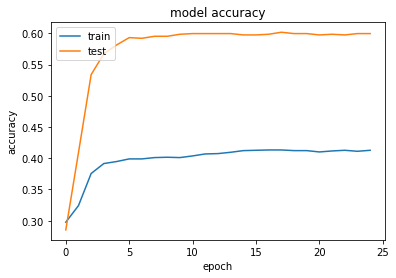

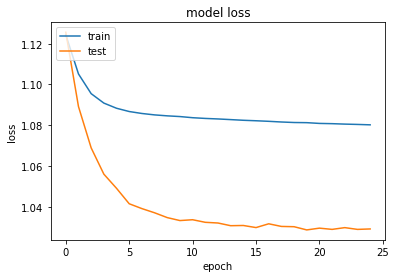

100/100 [==============================] - 0s


[1.0647132396697998, 0.5]


In [24]:
# LEARN
model = Sequential()
model.add(Dense(units=32, input_dim=len(TENSED_POS_TAGS))) # layer
model.add(Activation('relu')) # layer
model.add(Dense(units=64))
model.add(Activation('relu'))
model.add(Dense(units=3)) # layer
model.add(Activation('softmax')) #layer

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True),
              metrics=['accuracy']) # not layer

print(TAG_SET)

history = model.fit(np_array(x_train), np_array(y_train), validation_split=0.33, epochs=25, batch_size=32)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)
print(loss_and_metrics)